# Decision Tree

Use decision trees to prepare a model on fraud data 
treating those who have taxable_income <= 30000 as "Risky" and others are "Good"

Data Description :

Undergrad : person is under graduated or not
Marital.Status : marital status of a person
Taxable.Income : Taxable income is the amount of how much tax an individual owes to the government 
Work Experience : Work experience of an individual person
Urban : Whether that person belongs to urban area or not

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_csv(r"Fraud_check.csv")
print("data Shape:",data.shape)
data.tail()

data Shape: (600, 6)


,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO
599,NO,Divorced,96519,158137,16,NO


### EDA and Data Visualization

In [5]:
print('\n Describe:');   print(data.describe())
print('\n Info:');   print(data.info())
print('\n Null values:');   print(data.isnull().sum())
print('\n Duplicated:');   print(data[data.duplicated()])


 Describe:
       Taxable.Income  City.Population  Work.Experience
count      600.000000       600.000000       600.000000
mean     55208.375000    108747.368333        15.558333
std      26204.827597     49850.075134         8.842147
min      10003.000000     25779.000000         0.000000
25%      32871.500000     66966.750000         8.000000
50%      55074.500000    106493.500000        15.000000
75%      78611.750000    150114.250000        24.000000
max      99619.000000    199778.000000        30.000000

 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int6

## Variable check

### Find columns with the same values

In [6]:
# Find columns with the same values
columns_with_same_values = data.columns[data.nunique() == 1].tolist()

for column in columns_with_same_values:
    unique_values = data[column].unique()
    print(f"Unique values in the '{column}' column:")
    print(unique_values)
    print()

# excluding columns_with_same_values
data = data.drop(columns=columns_with_same_values)
print("excluded columns_with_same_values, nos:",columns_with_same_values ,",Final shape:", data.shape)

excluded columns_with_same_values, nos: [] ,Final shape: (600, 6)


In [7]:
# Discrete Variables Count
discrete_feature=[feature for feature in data.columns if len(data[feature].unique())<20 and feature]
print('Discrete Variables Count: {}'.format(len(discrete_feature)))
print(discrete_feature)

# Continuous Feature Count
continuous_feature=[feature for feature in data.columns if data[feature].dtype!='O' and feature not in discrete_feature]
print('\nContinuous Feature Count {}'.format(len(continuous_feature)))
print(continuous_feature)

# Other Features Count
other_feature = [feature for feature in data.columns if feature not in discrete_feature and feature not in continuous_feature]
print('\nOther Features Count: {}'.format(len(other_feature)))
print('Other Features: {}'.format(other_feature))

# Numeric Data
numeric_data = data.select_dtypes(include='number')
print('\nNumeric Data Shape:', numeric_data.shape)
print(numeric_data.columns)

# Categorical Data
categorical_data = data.select_dtypes(include='object')
print('\nCategorical Data Shape:', categorical_data.shape)
print('Categorical Columns:', categorical_data.columns)

Discrete Variables Count: 3
['Undergrad', 'Marital.Status', 'Urban']

Continuous Feature Count 3
['Taxable.Income', 'City.Population', 'Work.Experience']

Other Features Count: 0
Other Features: []

Numeric Data Shape: (600, 3)
Index(['Taxable.Income', 'City.Population', 'Work.Experience'], dtype='object')

Categorical Data Shape: (600, 3)
Categorical Columns: Index(['Undergrad', 'Marital.Status', 'Urban'], dtype='object')


## Categorical Data

Bar plot for all categorical

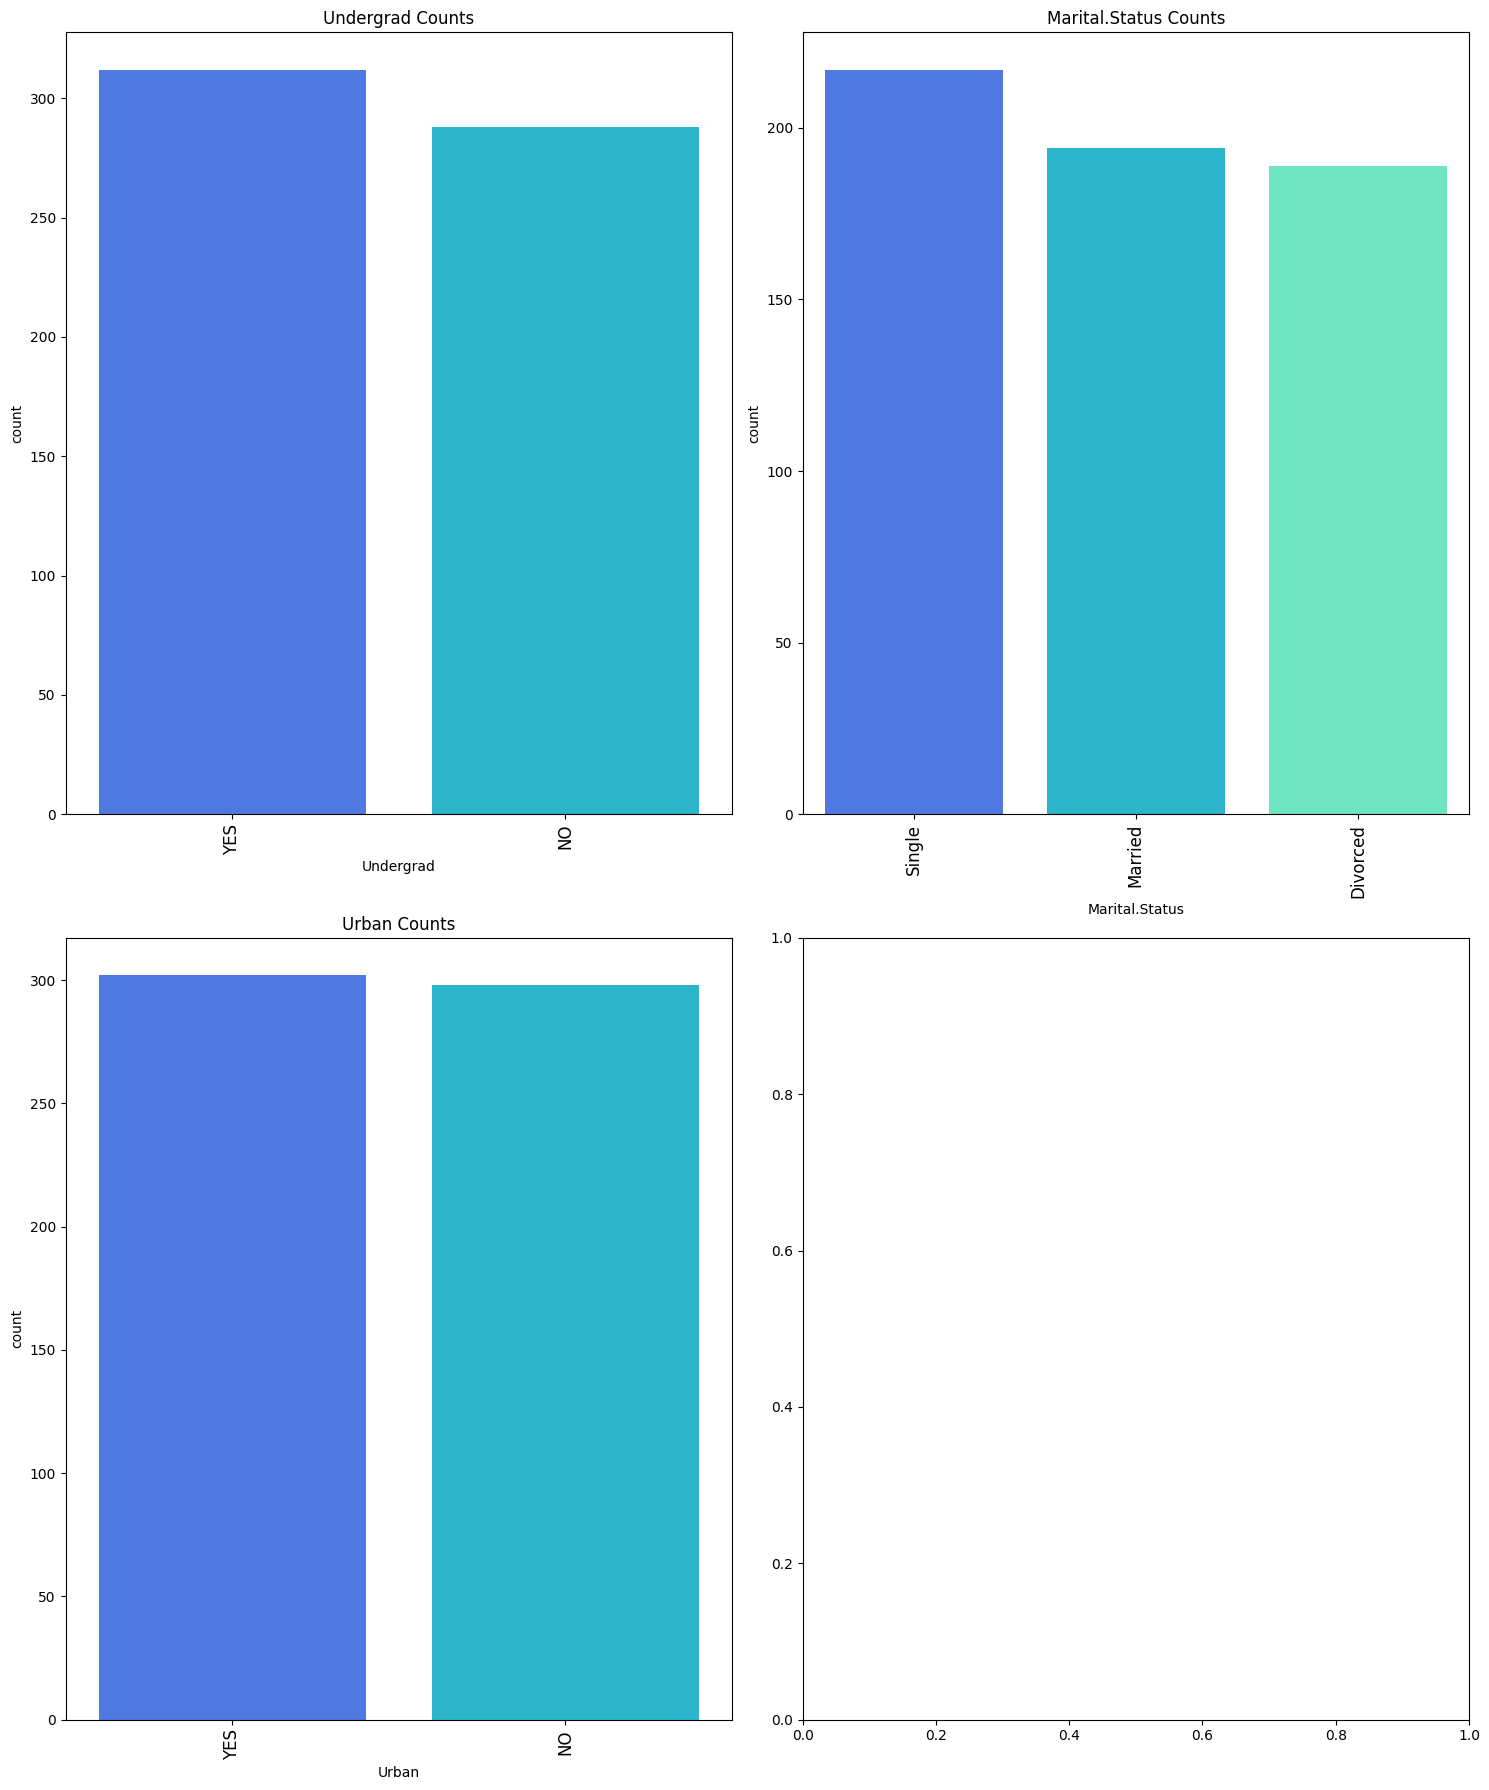

In [8]:
num_columns = len(categorical_data.columns)
num_rows = num_columns // 2 + num_columns % 2  # Ensure odd number of columns works correctly
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, num_rows * 9))

pal = sns.color_palette('rainbow')
for i, column in enumerate(categorical_data.columns):
    row_index = i // 2
    col_index = i % 2
    
    sns.countplot(x=column, data=categorical_data, palette=pal,
                  order=categorical_data[column].value_counts().index,
                  ax=axes[row_index, col_index])
    
    axes[row_index, col_index].set_xticklabels(axes[row_index, col_index].get_xticklabels(), rotation=90, fontsize=12)
    axes[row_index, col_index].set_title(f'{column} Counts')

# Adjust layout
plt.tight_layout()
plt.show()


### Labelencoder to convert categorical data into numeric

In [12]:
cat_data = categorical_data.copy()
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
for column in categorical_data.columns:
    cat_data[column] = label_encoder.fit_transform(cat_data[column])
    
    print(f"\nLabel Encoding for {column}:")
    # print("\n", cat_data[column].value_counts())
    unique_values = categorical_data[column].unique()

    for value in unique_values:
        label = label_encoder.transform([value])[0]
        counts = cat_data[column].value_counts()[label]
        print(f"Value: {value} -> Label: {label} --> Counts: {counts}")
    


Label Encoding for Undergrad:
Value: NO -> Label: 0 --> Counts: 288
Value: YES -> Label: 1 --> Counts: 312

Label Encoding for Marital.Status:
Value: Single -> Label: 2 --> Counts: 217
Value: Divorced -> Label: 0 --> Counts: 189
Value: Married -> Label: 1 --> Counts: 194

Label Encoding for Urban:
Value: YES -> Label: 1 --> Counts: 302
Value: NO -> Label: 0 --> Counts: 298


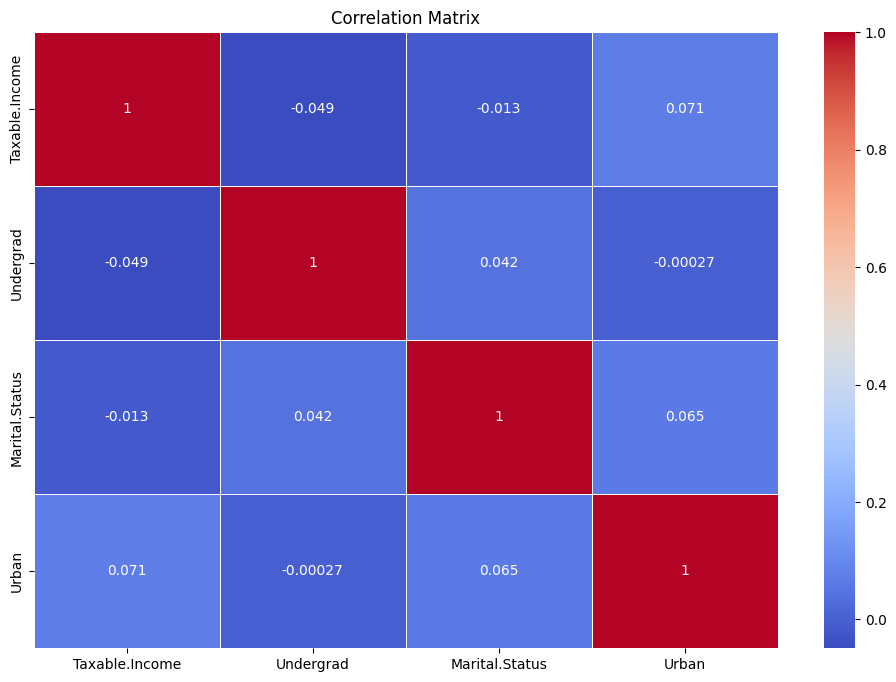

In [15]:
# Correlation Plot
cat_data=pd.concat([numeric_data['Taxable.Income'],cat_data],axis=1)
corr_matrix = cat_data.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

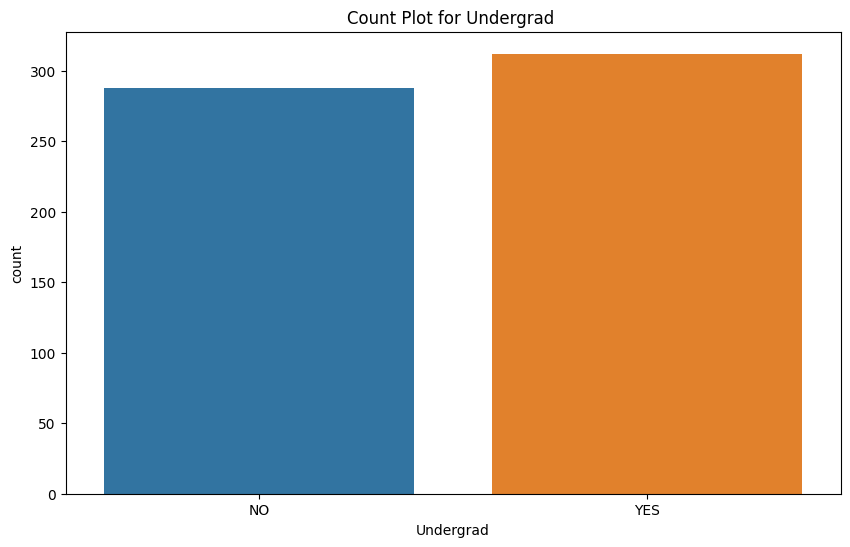

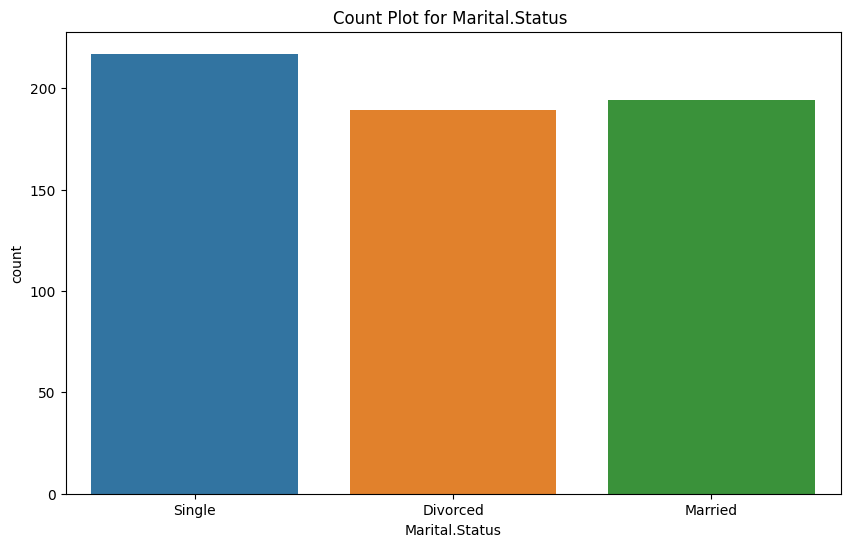

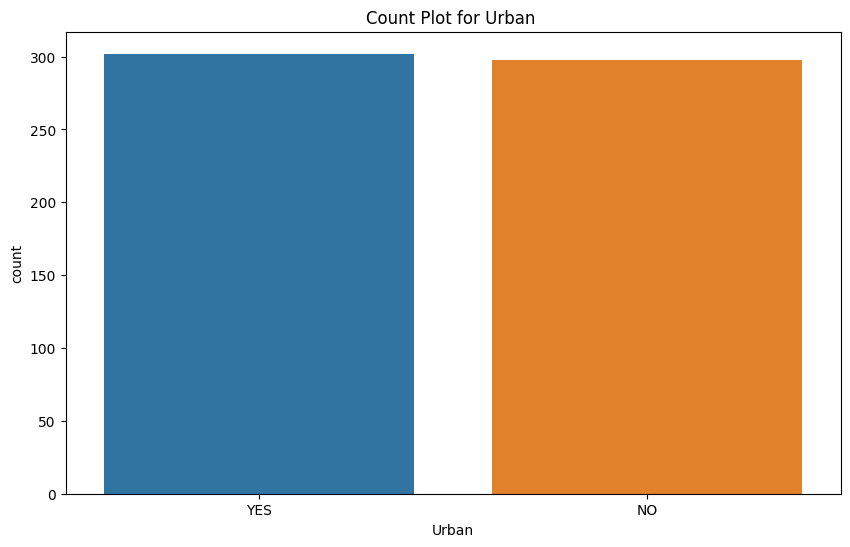

In [16]:
categorical_columns = categorical_data.columns
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=categorical_data, x=column)
    plt.title(f'Count Plot for {column} ')
    plt.show()

## Numeric Data

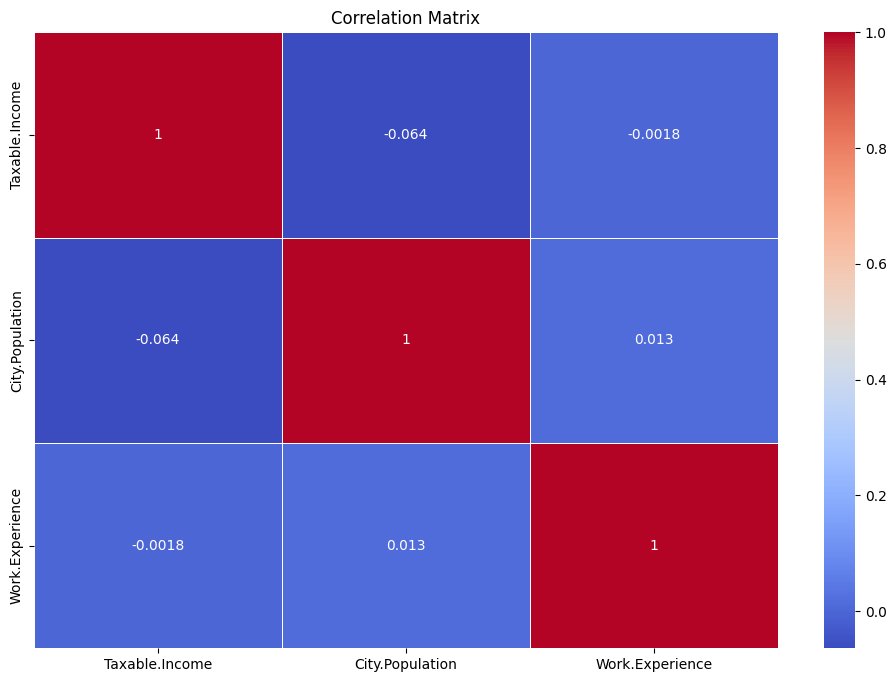

In [17]:
# Correlation Plot
corr_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

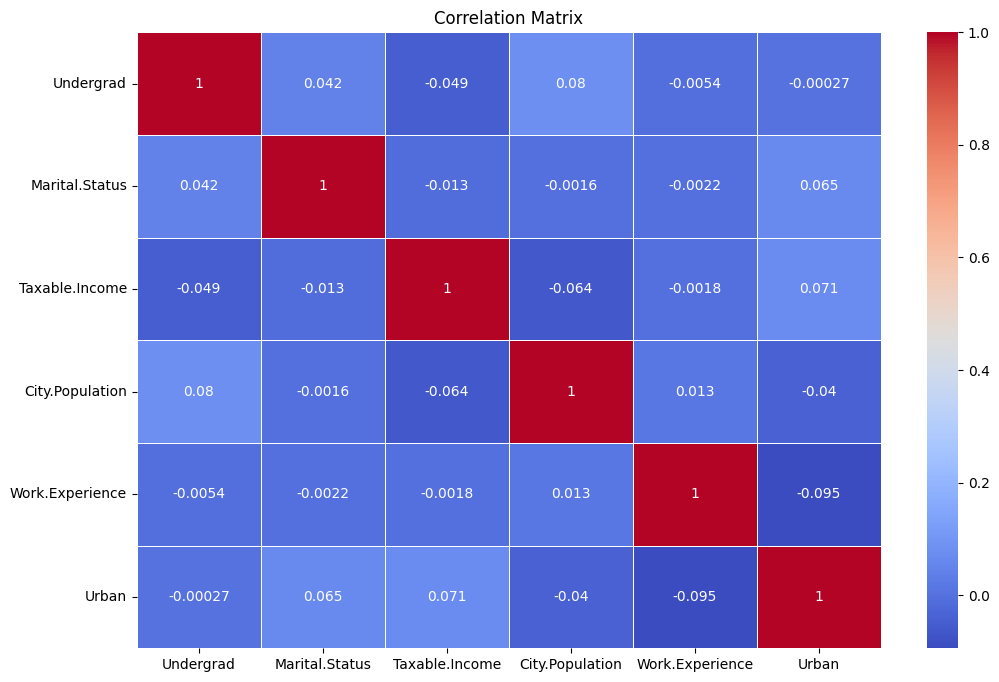

In [18]:
# Correlation Plot with All variable
data_2 = data.copy()
data_2[categorical_data.columns]=cat_data[categorical_data.columns]
corr_matrix = data_2.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### visualization

In [13]:
# # relationship plot for categorical data
# sns.pairplot(data= cat_data)
# plt.show()

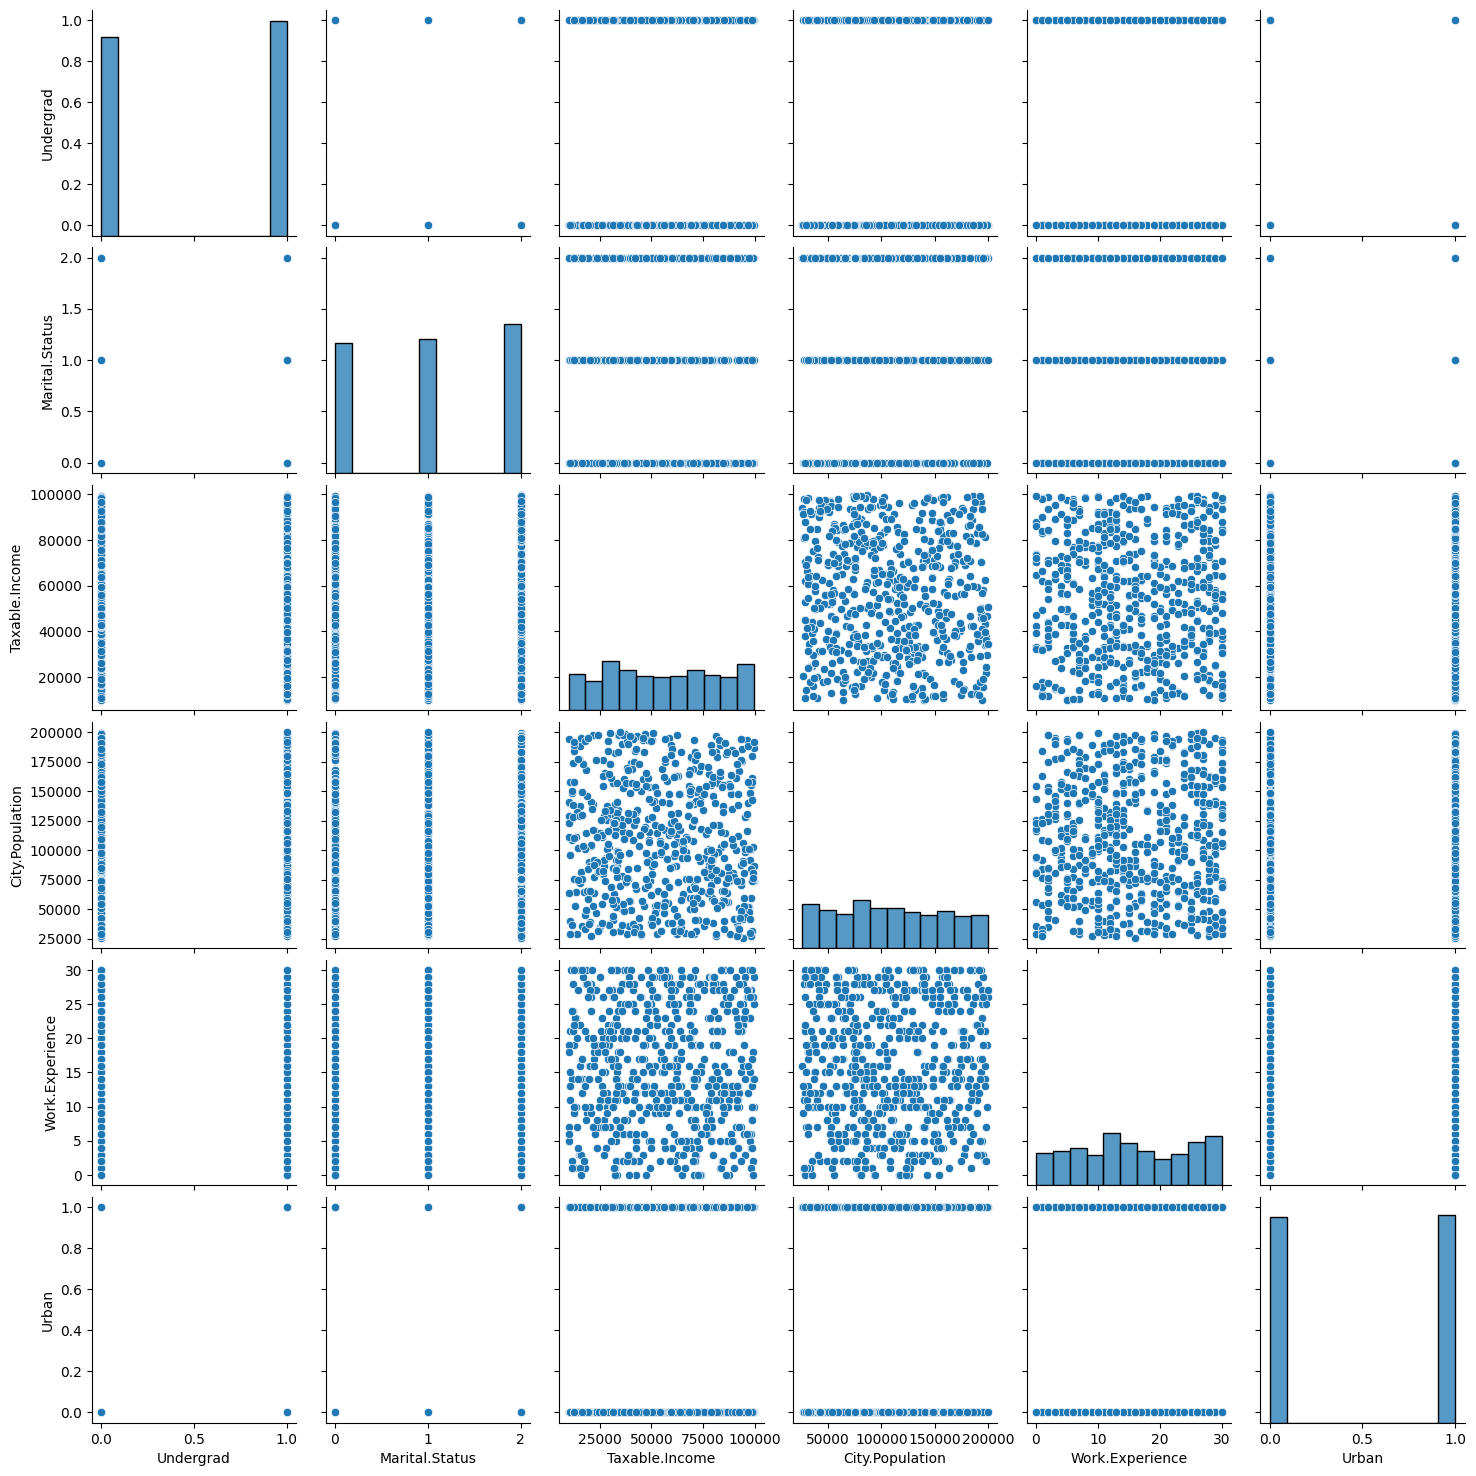

In [19]:
# relationship plot for All data
sns.pairplot(data= data_2)
plt.show()

### Detect outliers and handle them

In [20]:
data_filtered=data_2
# data_filtered=pd.concat([numeric_data,cat_data],axis=1)    #,cat_data ,numeric_data, data_2
data_filtered.shape

(600, 6)

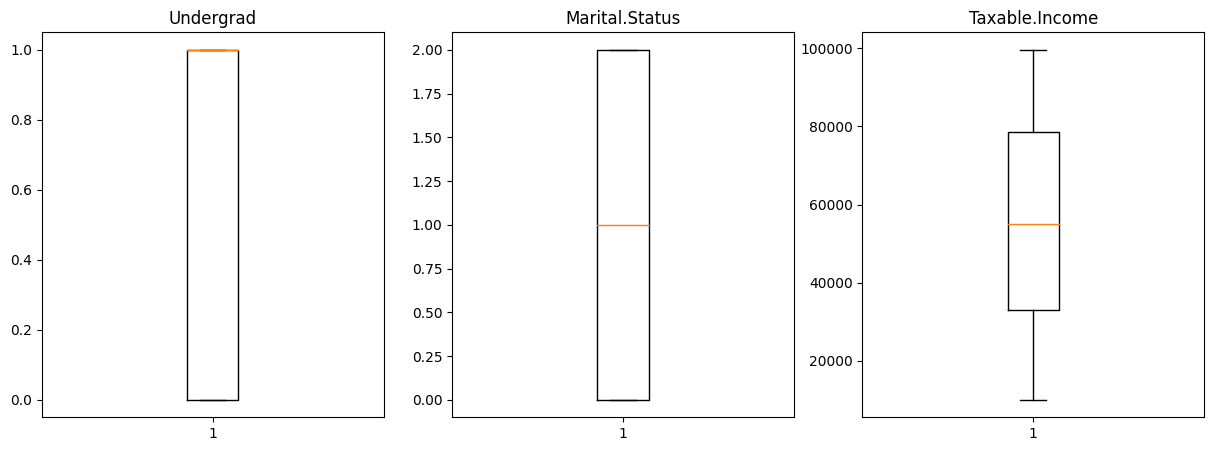

In [21]:
# display boxplots

num_columns = len(numeric_data.columns)
subplots_per_row = 3
num_rows = (num_columns + subplots_per_row - 1) // subplots_per_row

# Create subplots
fig, axes = plt.subplots(num_rows, subplots_per_row, figsize=(15, 5*num_rows))
axes = axes.flatten()

for i in range(num_columns):
    ax = axes[i]
    ax.boxplot(data_filtered.iloc[:, i])
    ax.set_title(data_filtered.columns[i])

# Hide any remaining empty subplots
for i in range(num_columns, num_rows * subplots_per_row):
    fig.delaxes(axes[i])

# plt.tight_layout()
plt.show()


#### Treating outliers with IQR

In [22]:
num_columns = len(numeric_data.columns)
new_data = data_filtered.copy()

for i in range(num_columns):
    # print("\n\nColumn Name:",(data_filtered.columns[i]))
    print("\n\nColumn Name: \033[1;34m" + "\033[1m" + data_filtered.columns[i] + "\033[0m")

    # Calculate the IQR
    Q1 = data_filtered.iloc[:, i].quantile(0.25)
    Q3 = data_filtered.iloc[:, i].quantile(0.75)
    IQR = Q3 - Q1
        
    # Identify and mark outliers using IQR
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(data_filtered[(data_filtered.iloc[:, i] > upper_bound) | (data_filtered.iloc[:, i] < lower_bound)].tail(2))
    
    # # Changing the outliers
    # new_data.loc[(new_data[data_filtered.columns[i]] > upper_bound), data_filtered.columns[i]] = upper_bound
    # new_data.loc[(new_data[data_filtered.columns[i]] < lower_bound), data_filtered.columns[i]] = lower_bound
    
    # # Drop rows with outliers
    # outliers = new_data[(new_data.iloc[:, i] < lower_bound) | (new_data.iloc[:, i] > upper_bound)].index   
    # new_data = new_data.drop(outliers)
    
print("\nShape of new data:",new_data.shape)
# sns.boxplot(data = new_data)
# plt.show()




Column Name: Undergrad
Empty DataFrame
Columns: [Undergrad, Marital.Status, Taxable.Income, City.Population, Work.Experience, Urban]
Index: []


Column Name: Marital.Status
Empty DataFrame
Columns: [Undergrad, Marital.Status, Taxable.Income, City.Population, Work.Experience, Urban]
Index: []


Column Name: Taxable.Income
Empty DataFrame
Columns: [Undergrad, Marital.Status, Taxable.Income, City.Population, Work.Experience, Urban]
Index: []

Shape of new data: (600, 6)


Note: not removing outliers, 

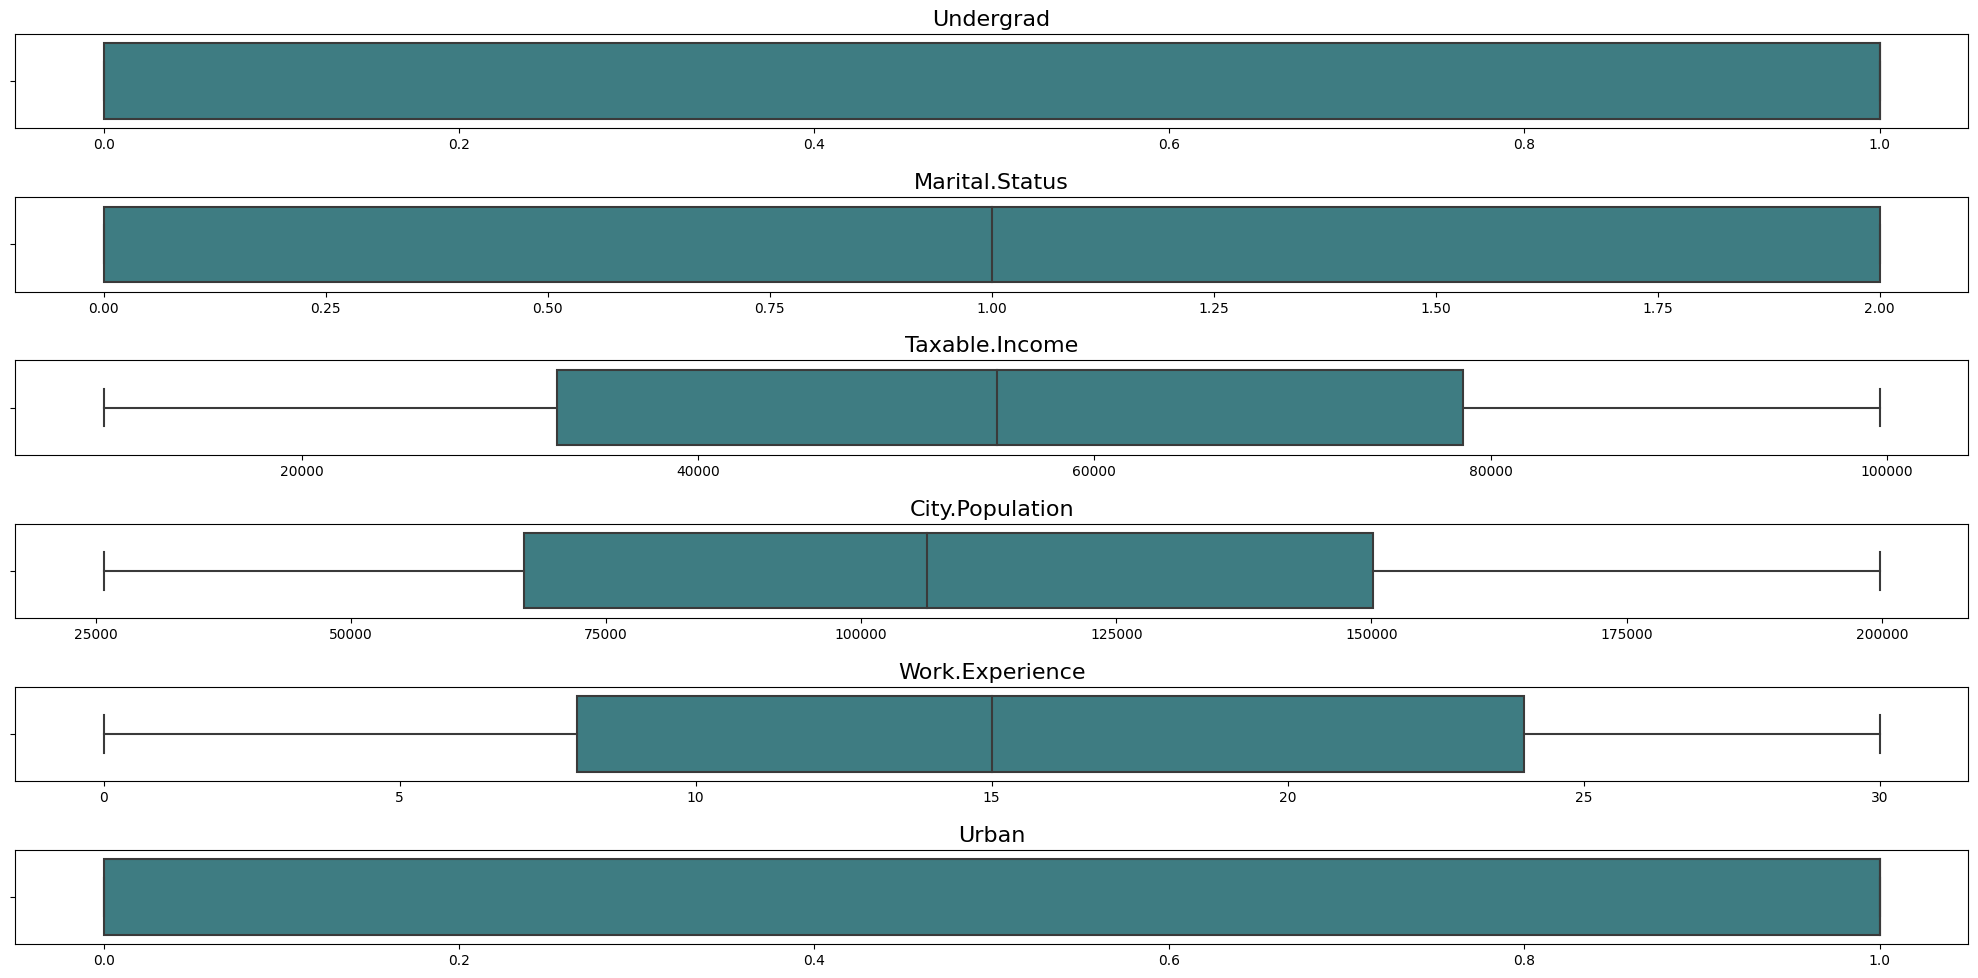

In [24]:
# display boxplots of Treated outliers with IQR

# Display boxplots
# Create subplots
fig, axes = plt.subplots(len(new_data.columns), 1, figsize=(20, 10), sharex=False, sharey=False)

# Loop through each variable and create boxplots
for i, variable in enumerate(new_data):
    sns.boxplot(x=variable, data=new_data, palette='crest', ax=axes[i])
    axes[i].set_title(f'{variable}', fontsize=16) 
    axes[i].set_xlabel('')  

plt.tight_layout(pad=1.5)
plt.show()


## distribution plots

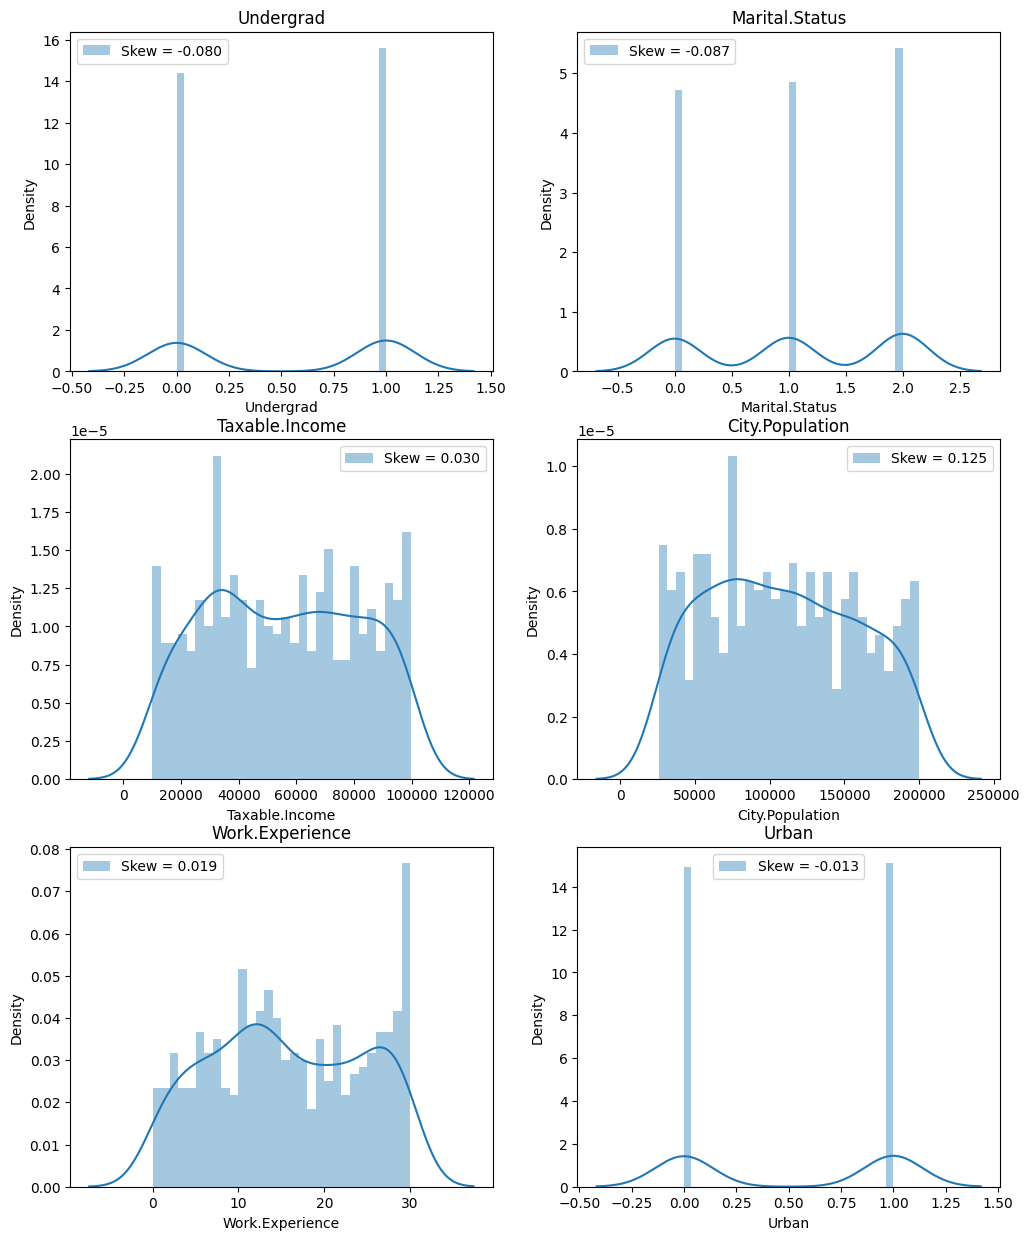

In [25]:
# distribution plots
subplots_per_row = 2
num_rows = (len(new_data.columns) + subplots_per_row - 1) // subplots_per_row
fig, axes = plt.subplots(num_rows, subplots_per_row, figsize=(12, 5*num_rows))
axes = axes.flatten()

for i, column in enumerate(new_data.columns):
    ax = axes[i]
    skew = new_data[column].skew()
    sns.distplot(new_data[column], kde= True, label='Skew = %.3f' %(skew), bins=30, ax=ax)
    ax.legend(loc='best')
    ax.set_title(column)
    
# Hide any remaining empty subplots
for i in range(len(new_data.columns), num_rows * subplots_per_row):
    fig.delaxes(axes[i])

# plt.tight_layout()
plt.show()


## Histogram & Probability Plot (Q-Q plot)

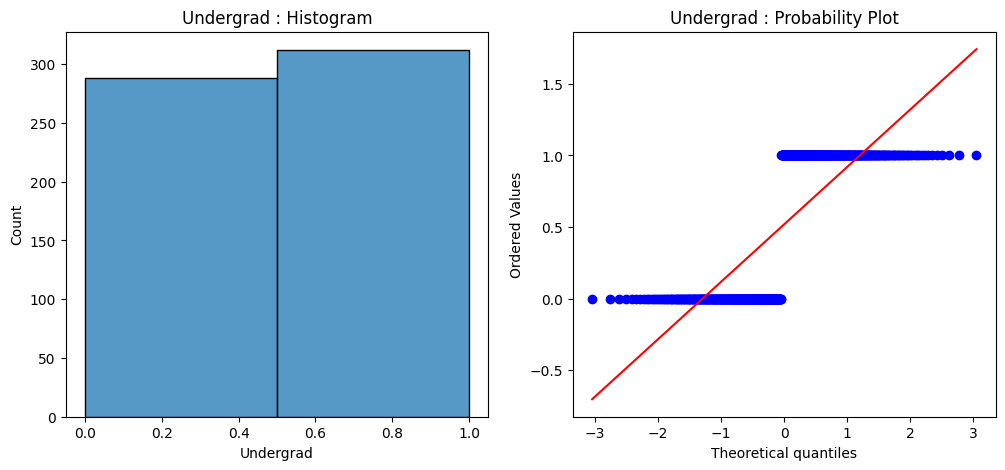

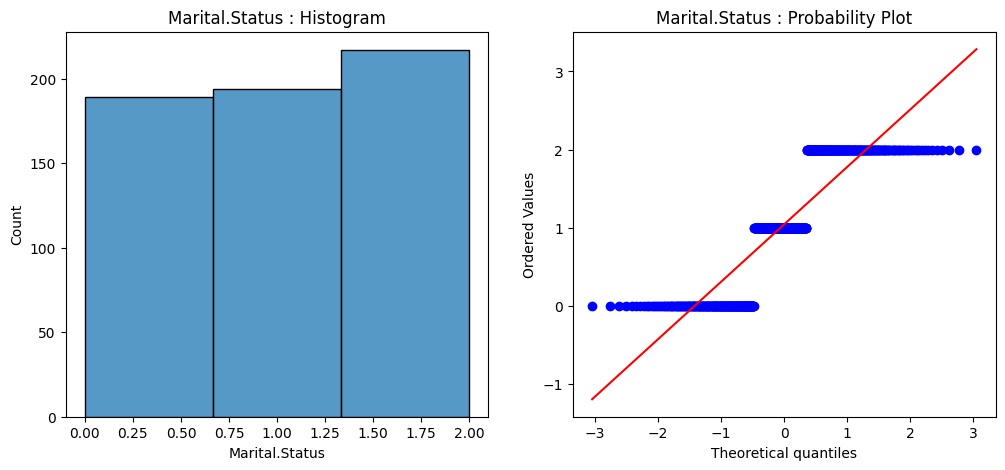

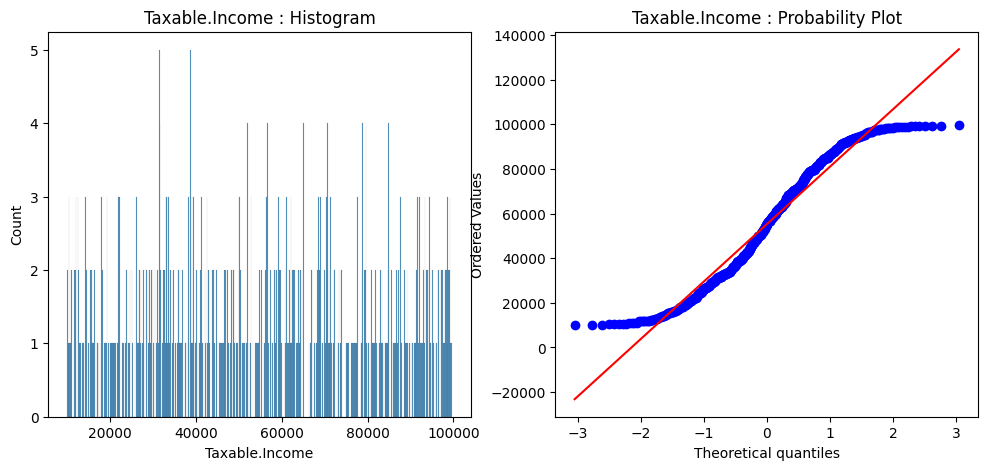

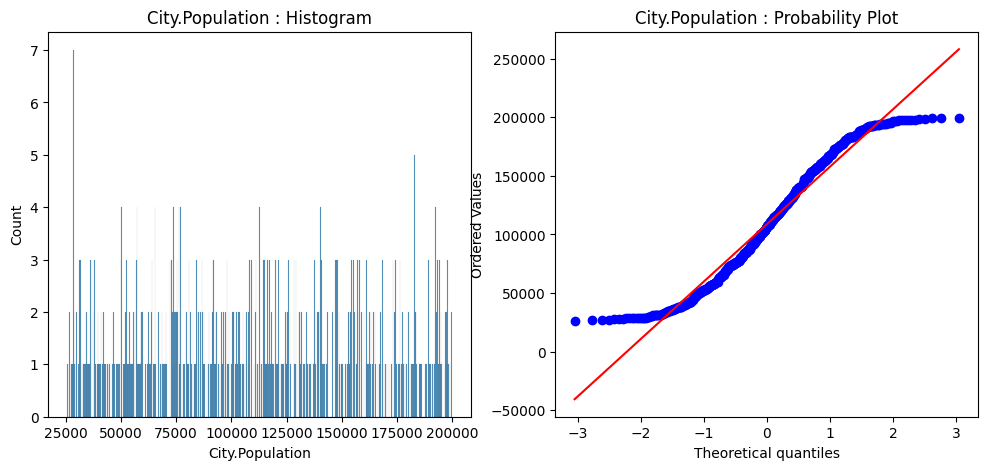

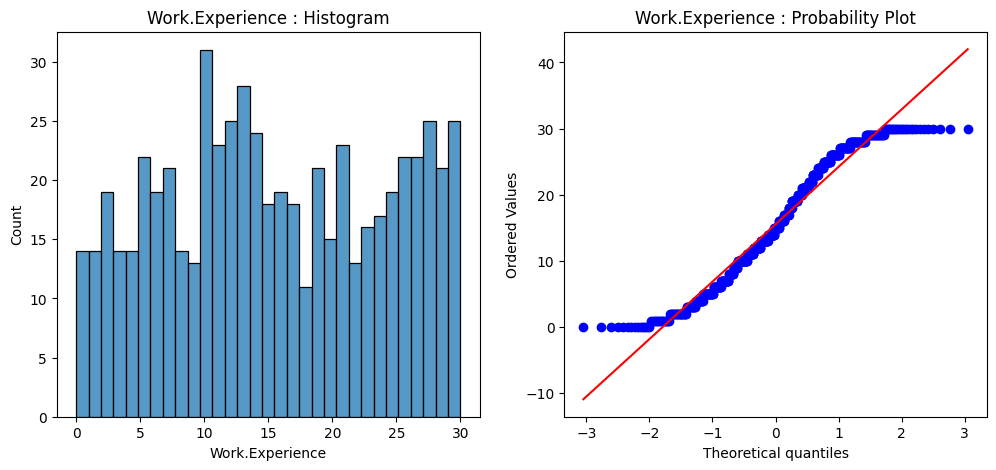

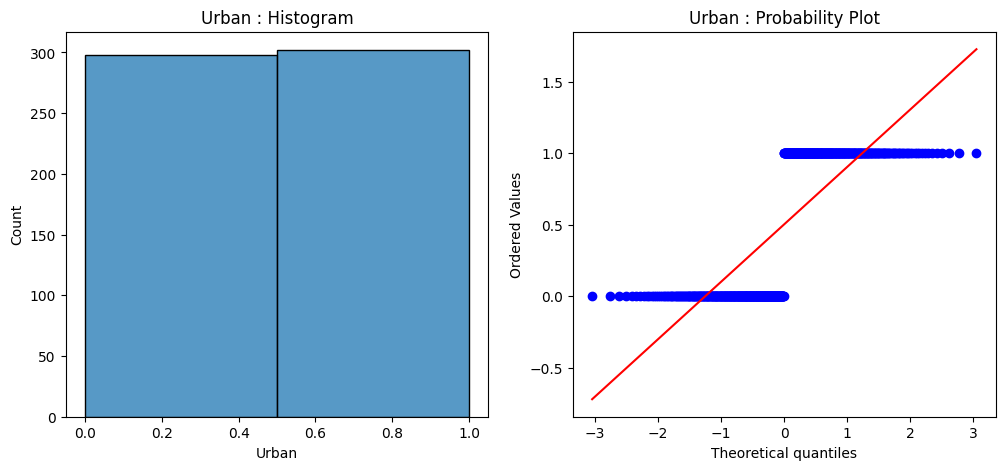

In [26]:
# Histogram & Probability Plot (Q-Q plot)
import pylab
import scipy.stats as stat

def plot_data(df, feature):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    # sns.barplot(x = df[feature].value_counts().index.tolist(), y = df[feature].value_counts().tolist())
    sns.histplot(df[feature], bins=len(df[feature].value_counts()))
    # df[feature].hist()
    plt.title(f'{feature} : Histogram')
    
    plt.subplot(1, 2, 2)
    stat.probplot(df[feature], dist='norm', plot=pylab)
    plt.title(f'{feature} : Probability Plot')

# Iterate through all columns
for column in new_data.columns:
    plot_data(new_data, column)
    plt.show()


# Analysing the Data

In [29]:
data_M=data.copy()
data_M

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO


In [30]:
# feature engineer
def split(num):
    if num <= 30000:
        return "Risky"
    else:
        return "Good"
    
data_M['Taxable.Income'] = data_M['Taxable.Income'].apply(split)
data_M

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,Good,50047,10,YES
1,YES,Divorced,Good,134075,18,YES
2,NO,Married,Good,160205,30,YES
3,YES,Single,Good,193264,15,YES
4,NO,Married,Good,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,Good,39492,7,YES
596,YES,Divorced,Good,55369,2,YES
597,NO,Divorced,Good,154058,0,YES
598,YES,Married,Good,180083,17,NO


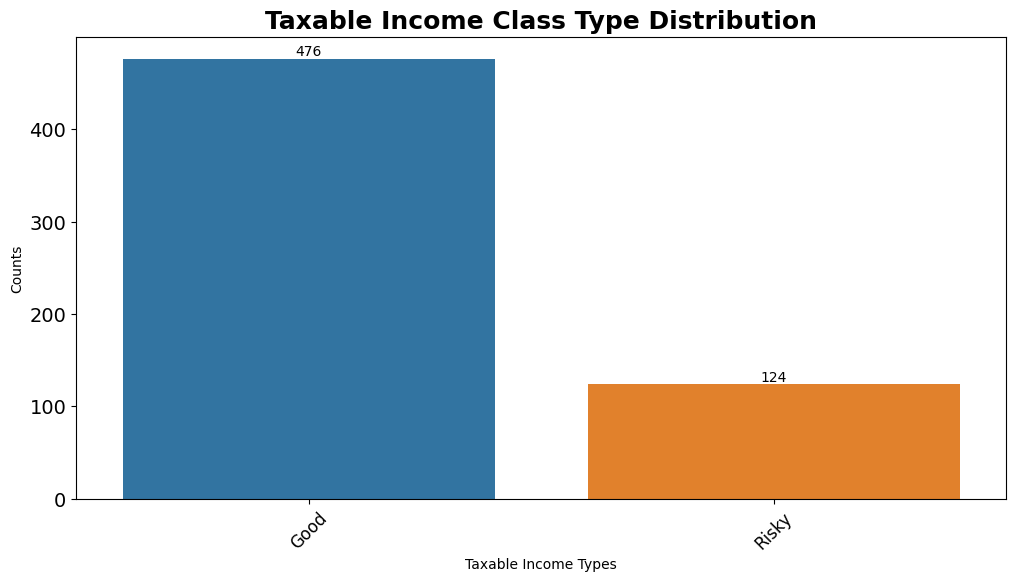

In [35]:
plt.figure(figsize = (12,6))
ax = sns.barplot(x = data_M['Taxable.Income'].value_counts().index.tolist(), y = data_M['Taxable.Income'].value_counts().tolist()) 
                # 'ax' -  to add labels to the bars
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 45, fontsize = 12)
plt.title("Taxable Income Class Type Distribution",  fontsize = 18, fontweight = 'bold')
plt.xlabel('Taxable Income Types')
plt.ylabel('Counts')
# Add labels to the bars
for i in ax.containers:
    ax.bar_label(i,)

### Feature scaling

In [45]:
columns_to_encode = data_M.columns[data_M.columns != 'Taxable.Income']
df_num = pd.get_dummies(data_M[columns_to_encode])
df_num['Taxable.Income'] = data_M['Taxable.Income']
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
df_num['Taxable.Income'] = LE.fit_transform(df_num['Taxable.Income'])
df_num.tail()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES,Taxable.Income
595,39492,7,False,True,True,False,False,False,True,0
596,55369,2,False,True,True,False,False,False,True,0
597,154058,0,True,False,True,False,False,False,True,0
598,180083,17,False,True,False,True,False,True,False,0
599,158137,16,True,False,True,False,False,True,False,0


# Model Building  & Testing

In [46]:
# x_train = new_data.iloc[:,:-1]    # new_data
# y_train = new_data.iloc[:,-1]
# x_test = new_data.iloc[:,:-1]
# y_test = new_data.iloc[:,-1]

X = df_num.drop(['Taxable.Income'],axis=1)
y = df_num[['Taxable.Income']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)
X_train

Shape of X_train:  (480, 9)
Shape of X_test:  (120, 9)
Shape of y_train:  (480, 1)
Shape of y_test (120, 1)


,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES
82,111068,26,True,False,True,False,False,False,True
568,150036,22,True,False,False,False,True,False,True
347,80991,0,True,False,False,True,False,False,True
544,133877,21,True,False,False,False,True,False,True
34,183767,1,False,True,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...
129,65469,26,False,True,False,False,True,True,False
144,156503,29,False,True,False,False,True,False,True
72,108300,27,False,True,True,False,False,False,True
235,87541,9,True,False,True,False,False,True,False


## standardization

In [47]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train

array([[ 0.04453457,  1.16220147,  1.03823026, ..., -0.7574764 ,
        -1.0296047 ,  1.0296047 ],
       [ 0.8322421 ,  0.71186306,  1.03823026, ...,  1.32017315,
        -1.0296047 ,  1.0296047 ],
       [-0.56344838, -1.7649982 ,  1.03823026, ..., -0.7574764 ,
        -1.0296047 ,  1.0296047 ],
       ...,
       [-0.01141838,  1.27478607, -0.96317747, ..., -0.7574764 ,
        -1.0296047 ,  1.0296047 ],
       [-0.43104527, -0.75173677,  1.03823026, ..., -0.7574764 ,
         0.97124654, -0.97124654],
       [-0.84804431, -1.20207518,  1.03823026, ..., -0.7574764 ,
        -1.0296047 ,  1.0296047 ]])

# Decision tree modeling

In [48]:
from sklearn.tree import DecisionTreeClassifier
model1 = DecisionTreeClassifier(criterion='entropy', max_depth=3)
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
y_pred1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [49]:
from sklearn.tree import DecisionTreeClassifier
model2 = DecisionTreeClassifier(criterion='gini', max_depth=4)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
y_pred2

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Accuracy & classification report

model1:

In [50]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred1)
print(f"Accuracy: {accuracy}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred1))

Accuracy: 0.8083333333333333
Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89        97
           1       0.00      0.00      0.00        23

    accuracy                           0.81       120
   macro avg       0.40      0.50      0.45       120
weighted avg       0.65      0.81      0.72       120



model2:

In [51]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred2)
print(f"Accuracy: {accuracy}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred2))

Accuracy: 0.75
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.92      0.86        97
           1       0.11      0.04      0.06        23

    accuracy                           0.75       120
   macro avg       0.46      0.48      0.46       120
weighted avg       0.67      0.75      0.70       120



## confusion matrix

model1:


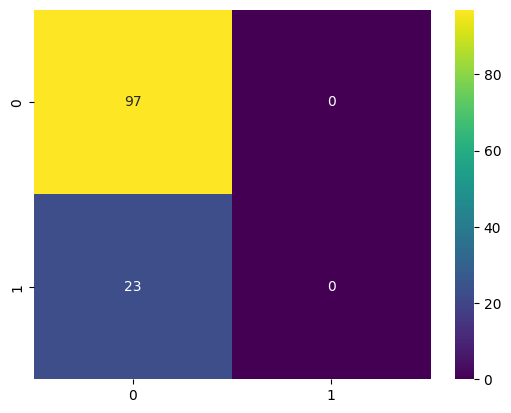

model2:


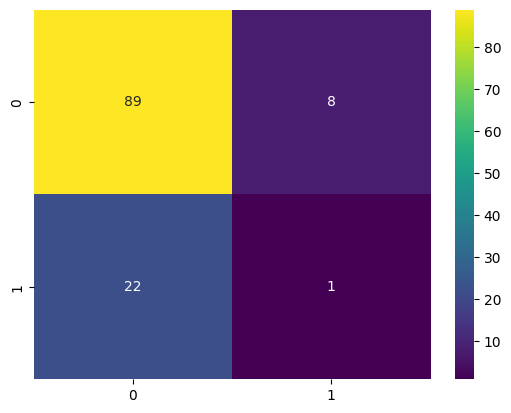

In [52]:
from sklearn.metrics import confusion_matrix
print('model1:')
sns.heatmap(confusion_matrix(y_test, y_pred1), annot=True, cmap = 'viridis', fmt='.0f')
plt.show()

print('model2:')
sns.heatmap(confusion_matrix(y_test, y_pred2), annot=True, cmap = 'viridis', fmt='.0f')
plt.show()

## compare the actual with the predicted:

model1:


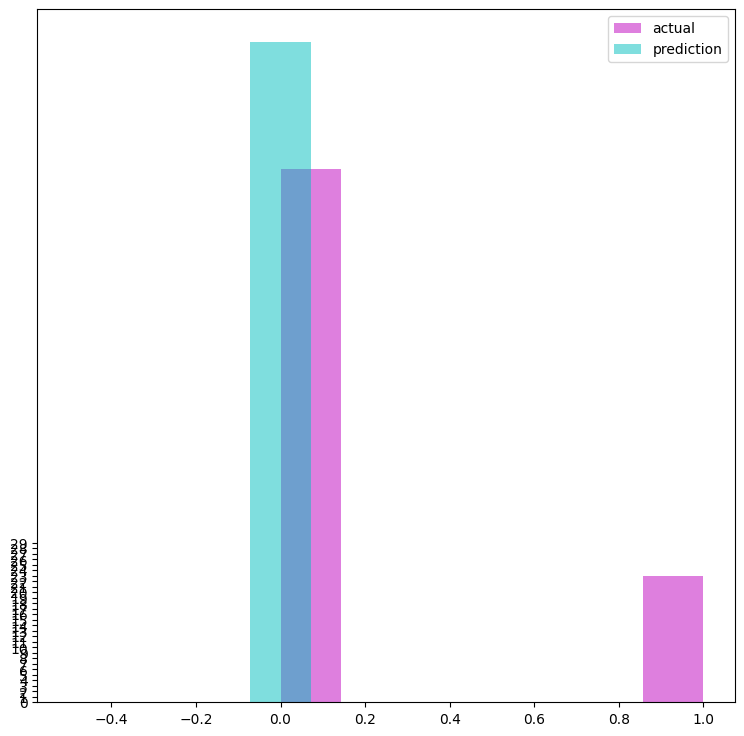

model2:


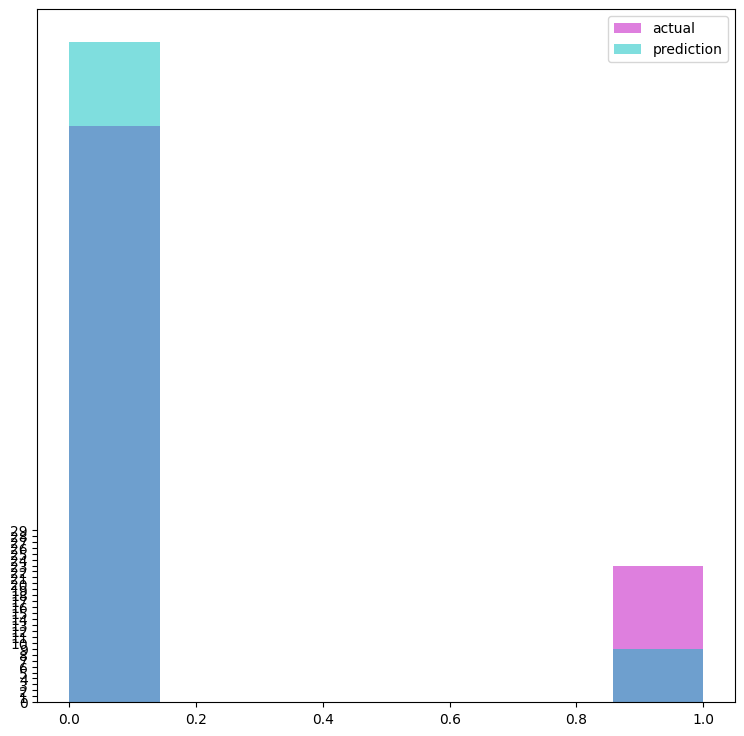

In [53]:
print('model1:')
plt.rcParams['figure.figsize'] = (9,9) 
fig, ax = plt.subplots()
ax.hist(y_test, color = 'm', alpha = 0.5, label = 'actual', bins=7)
ax.hist(y_pred1, color = 'c', alpha = 0.5, label = 'prediction', bins=7)
ax.yaxis.set_ticks(np.arange(0,30))
ax.legend(loc = 'best')
plt.show()

print('model2:')
plt.rcParams['figure.figsize'] = (9,9) 
fig, ax = plt.subplots()
ax.hist(y_test, color = 'm', alpha = 0.5, label = 'actual', bins=7)
ax.hist(y_pred2, color = 'c', alpha = 0.5, label = 'prediction', bins=7)
ax.yaxis.set_ticks(np.arange(0,30))
ax.legend(loc = 'best')
plt.show()

## Precision, Recall, and F1-Score:

In [54]:
from sklearn.metrics import precision_score, recall_score, f1_score
print('model1:')
precision = precision_score(y_test, y_pred1, average='weighted')
recall = recall_score(y_test, y_pred1, average='weighted')
f1 = f1_score(y_test, y_pred1, average='weighted')
print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

print('\nmodel2:')
precision = precision_score(y_test, y_pred2, average='weighted')
recall = recall_score(y_test, y_pred2, average='weighted')
f1 = f1_score(y_test, y_pred2, average='weighted')
print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

model1:
Precision: 0.6534027777777778, Recall: 0.8083333333333333, F1-Score: 0.7226574500768049

model2:
Precision: 0.6694194194194195, Recall: 0.75, F1-Score: 0.7037259615384615


## ROC Curve: Multi Classification problem

model1:


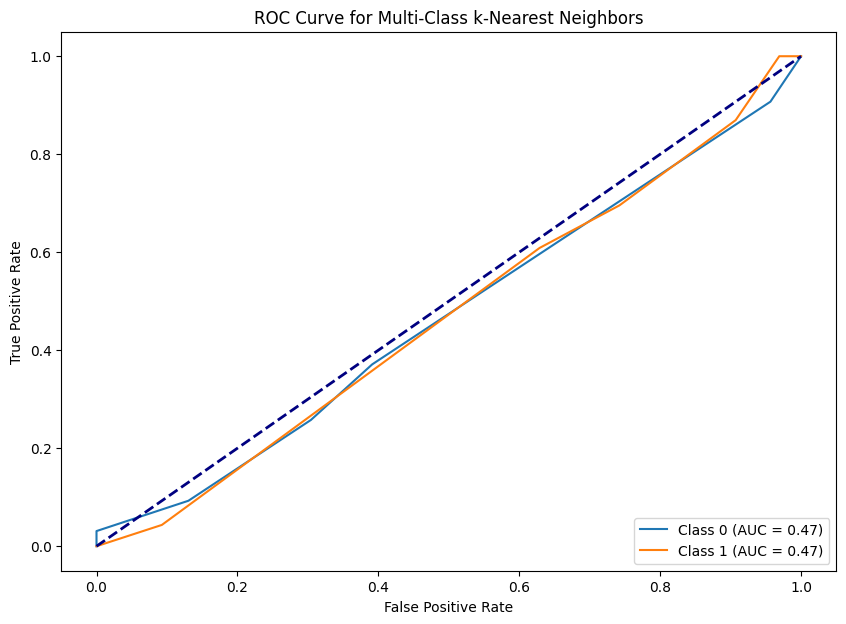


model2:


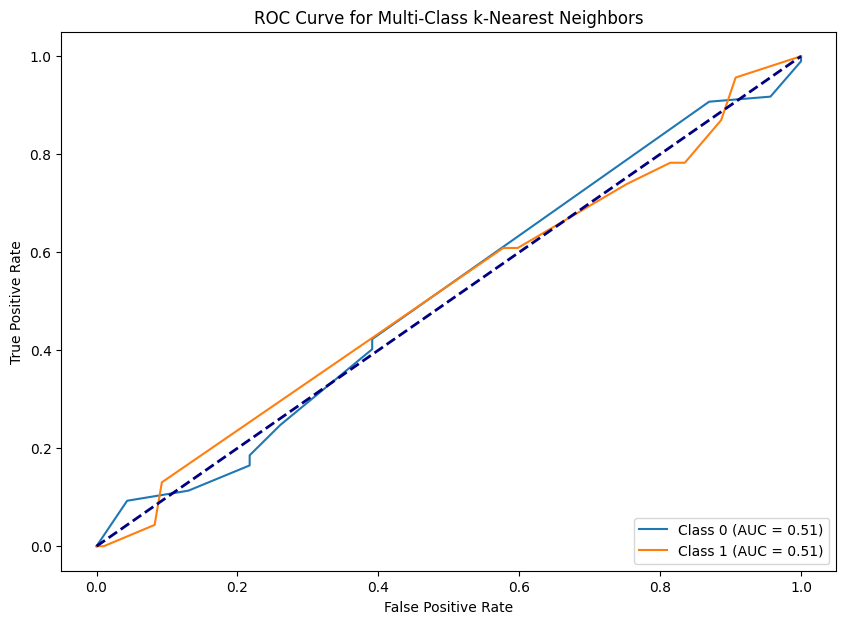

In [55]:
from sklearn.metrics import roc_curve, auc

print('model1:')
y_score = model1.predict_proba(X_test)
# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
uniq_out=np.unique(y_train)
num_classes = len(np.unique(y_train))
for i in range(num_classes):
    fpr, tpr, thresholds = roc_curve(y_test == uniq_out[i], y_score[:, i], pos_label=True)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {uniq_out[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class k-Nearest Neighbors')
plt.legend(loc='lower right')
plt.show()

print('\nmodel2:')
y_score = model2.predict_proba(X_test)
# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(num_classes):
    fpr, tpr, thresholds = roc_curve(y_test == uniq_out[i], y_score[:, i], pos_label=True)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {uniq_out[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class k-Nearest Neighbors')
plt.legend(loc='lower right')
plt.show()

Decision Tree Visualization:

model1:


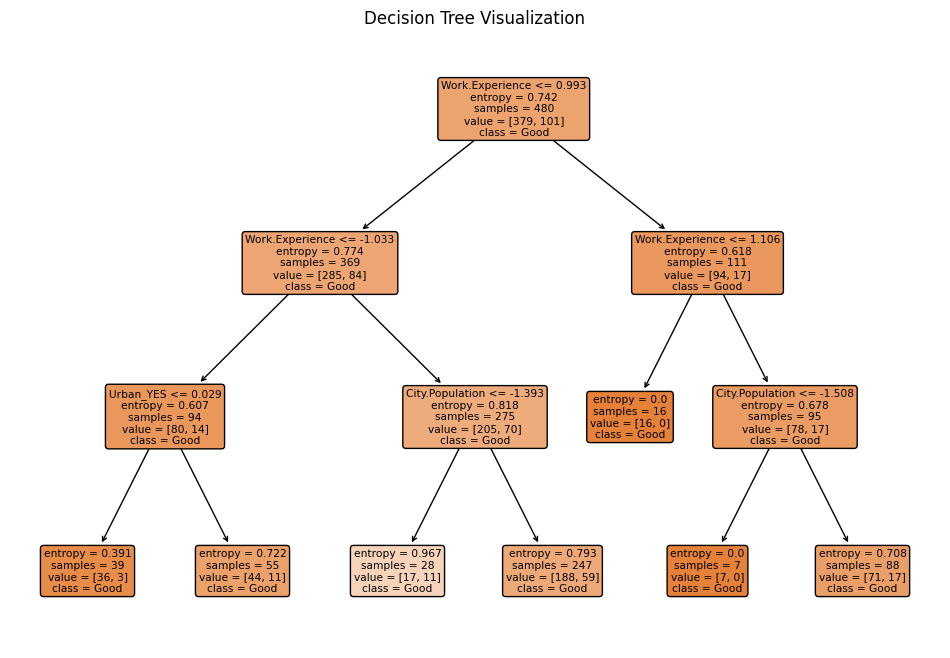


model2:


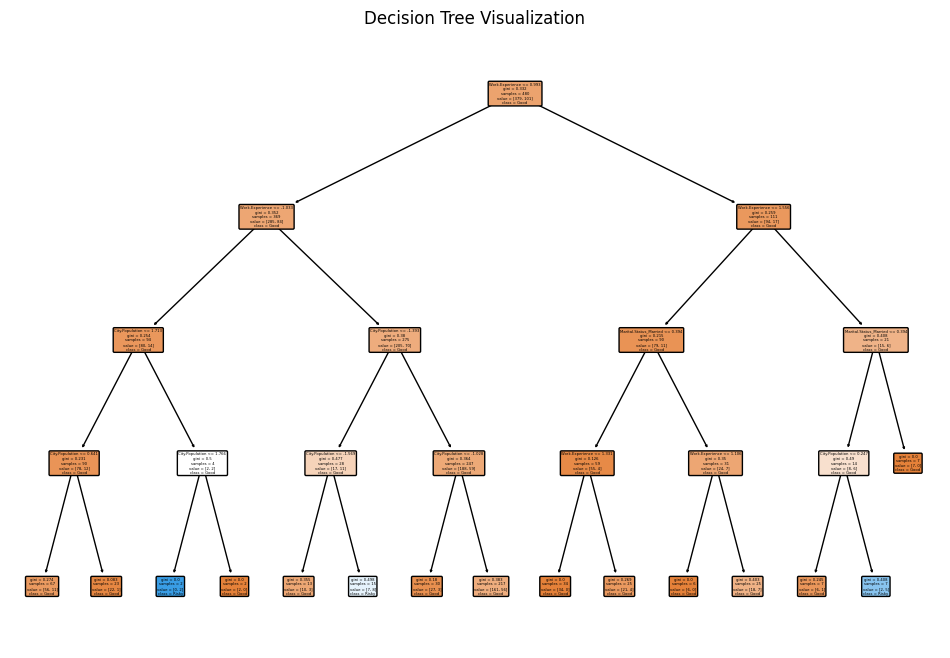

In [57]:
from sklearn.tree import plot_tree

feature_names = X.columns.tolist()
target_names = data_M['Taxable.Income'].unique().astype(str).tolist()
print('model1:')
# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(model1, filled=True, rounded=True, feature_names=feature_names, class_names=target_names)
plt.title("Decision Tree Visualization")
plt.show()

print('\nmodel2:')
# Plot the decision tree 
plt.figure(figsize=(12, 8))
plot_tree(model2, filled=True, rounded=True, feature_names=feature_names, class_names=target_names)
plt.title("Decision Tree Visualization")
plt.show()

##  model validation techniques

In [58]:
model1 = DecisionTreeClassifier(criterion='entropy', max_depth=3)
X = sc.fit_transform(X)

Cross-Validation:

In [59]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model1, X, y, cv=5)  # 5-fold cross-validation
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())


Cross-Validation Scores: [0.8        0.79166667 0.78333333 0.79166667 0.78333333]
Mean Accuracy: 0.7899999999999999


Stratified K-Fold Cross-Validation:

In [60]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model1, X, y, cv=skf)
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())


Cross-Validation Scores: [0.8        0.75833333 0.79166667 0.78333333 0.79166667]
Mean Accuracy: 0.7849999999999999


Leave-One-Out Cross-Validation (LOOCV):

In [61]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
scores = cross_val_score(model1, X, y, cv=loo)
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())


Cross-Validation Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1.
 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1.
 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1

Shuffle-Split Cross-Validation:

In [62]:
from sklearn.model_selection import ShuffleSplit

ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
scores = cross_val_score(model1, X, y, cv=ss)
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())


Cross-Validation Scores: [0.775      0.80833333 0.78333333 0.75833333 0.80833333]
Mean Accuracy: 0.7866666666666667


Time Series Split:

In [63]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(model1, X, y, cv=tscv)
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())

Cross-Validation Scores: [0.7  0.79 0.76 0.83 0.86]
Mean Accuracy: 0.788
